In [1]:
import pandas as pd
import numpy as np
import utils
import model

from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
sqlForTraining = """
select
	eta.idetablissement,
	eta.departement,
	eta.siren,
	eta.geores_lat,
	eta.geores_lon,
	eta.nb_agrements,
	eta.evolution_score,
	act.idactivite,
	act.categorie_frais,
	CASE 
      WHEN ins.synthese_eval = 'Très satisfaisant'  THEN 4
      WHEN ins.synthese_eval = 'Satisfaisant'  THEN 3
      WHEN ins.synthese_eval = 'A améliorer'  THEN 2
      WHEN ins.synthese_eval = 'A corriger de manière urgente'  THEN 1
	END	as synthese_eval
from inspection ins
join etablissement eta on ins.idetablissement = eta.idetablissement
join activite act on ins.idactivite = act.idactivite
order by eta.idetablissement
"""



In [3]:
df = pd.read_sql_query(sqlForTraining, model.session.connection())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35586 entries, 0 to 35585
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idetablissement  35586 non-null  int64  
 1   departement      35586 non-null  int64  
 2   siren            35586 non-null  object 
 3   geores_lat       35586 non-null  float64
 4   geores_lon       35586 non-null  float64
 5   nb_agrements     35586 non-null  int64  
 6   evolution_score  35586 non-null  float64
 7   idactivite       35586 non-null  int64  
 8   categorie_frais  35586 non-null  bool   
 9   synthese_eval    35586 non-null  int64  
dtypes: bool(1), float64(3), int64(5), object(1)
memory usage: 2.5+ MB


In [4]:
X = df[['geores_lat', 'geores_lon', 'nb_agrements', 'evolution_score', 'idactivite', 'categorie_frais']]
X['categorie_frais'] = X['categorie_frais'].astype('int')
y = df['synthese_eval']

C:\Users\jean\AppData\Local\Temp\ipykernel_10540\668420174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categorie_frais'] = X['categorie_frais'].astype('int')


In [5]:
print(np.unique(y, return_counts=True))

(array([1, 2, 3, 4], dtype=int64), array([  114,  1661, 18812, 14999], dtype=int64))


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35586 entries, 0 to 35585
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geores_lat       35586 non-null  float64
 1   geores_lon       35586 non-null  float64
 2   nb_agrements     35586 non-null  int64  
 3   evolution_score  35586 non-null  float64
 4   idactivite       35586 non-null  int64  
 5   categorie_frais  35586 non-null  int32  
dtypes: float64(3), int32(1), int64(2)
memory usage: 1.5 MB


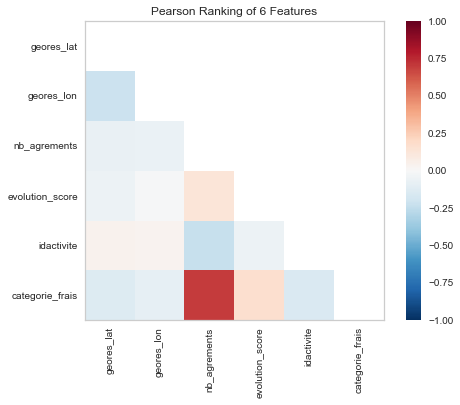

<AxesSubplot:title={'center':'Pearson Ranking of 6 Features'}>

In [7]:
from yellowbrick.features import Rank2D

r2D = Rank2D(algorithm='pearson')
r2D.fit(X)
r2D.transform(X)
r2D.show()

In [8]:
print(np.corrcoef(X, rowvar=False))

[[ 1.         -0.21744165 -0.07529121 -0.06228465  0.03985052 -0.13783015]
 [-0.21744165  1.         -0.06985461 -0.01418953  0.0335924  -0.09184368]
 [-0.07529121 -0.06985461  1.          0.12636984 -0.22826236  0.69646799]
 [-0.06228465 -0.01418953  0.12636984  1.         -0.0556613   0.16882668]
 [ 0.03985052  0.0335924  -0.22826236 -0.0556613   1.         -0.15363409]
 [-0.13783015 -0.09184368  0.69646799  0.16882668 -0.15363409  1.        ]]


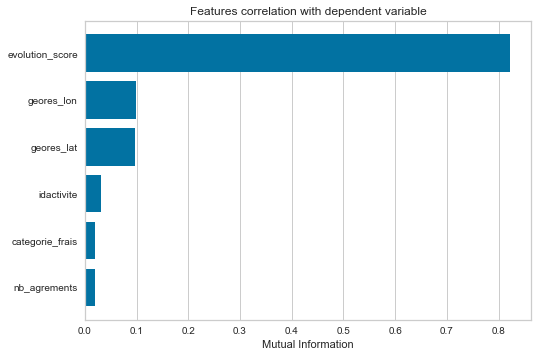

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [9]:
from yellowbrick.target import FeatureCorrelation
fc = FeatureCorrelation(method='mutual_info-classification', sort=True)
fc.fit(X, y, discrete_features=False)
fc.show()

In [10]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [11]:
print(yTrain.value_counts(normalize=True))
print(yTest.value_counts(normalize=True))


3    0.528629
4    0.421491
2    0.046684
1    0.003197
Name: synthese_eval, dtype: float64
3    0.528660
4    0.421467
2    0.046642
1    0.003231
Name: synthese_eval, dtype: float64


In [12]:
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()

In [13]:
ZTrain = stdSc.fit_transform(XTrain)
ZTest = stdSc.transform(XTest)

In [14]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(solver='liblinear')
reg.fit(ZTrain, yTrain)

LogisticRegression(solver='liblinear')

C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


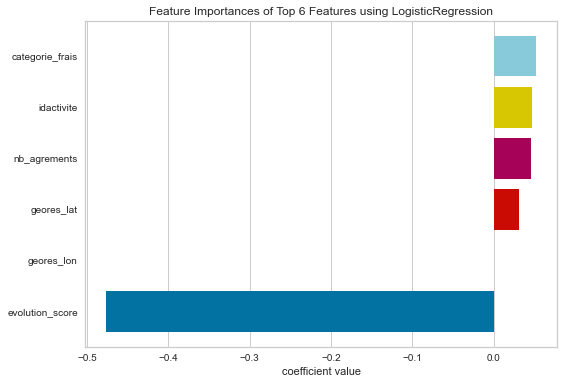

<AxesSubplot:title={'center':'Feature Importances of Top 6 Features using LogisticRegression'}, xlabel='coefficient value'>

In [15]:
from yellowbrick.model_selection import FeatureImportances
clfFI = FeatureImportances(LogisticRegression(solver='liblinear'), relative=False, topn=6, labels=XTrain.columns)
clfFI.fit(ZTrain, yTrain)
clfFI.show()

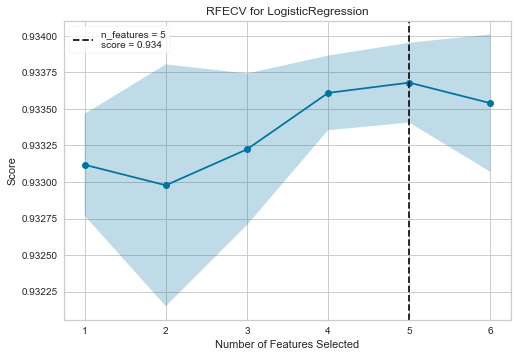

<AxesSubplot:title={'center':'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [16]:
from yellowbrick.model_selection import RFECV
from sklearn.metrics import make_scorer, f1_score
clfFE = RFECV(LogisticRegression(solver='liblinear'), cv=3, scoring=make_scorer(f1_score,average='micro'))
clfFE.fit(ZTrain, yTrain)
clfFE.show()

In [17]:
print(XTrain.columns[clfFE.support_==False])

Index(['geores_lat'], dtype='object')


C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


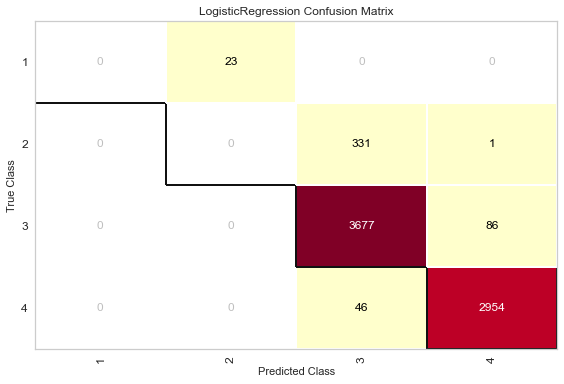

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
from yellowbrick.classifier import ConfusionMatrix
clfConfusion = ConfusionMatrix(reg)
clfConfusion.score(ZTest, yTest)
clfConfusion.show()

C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


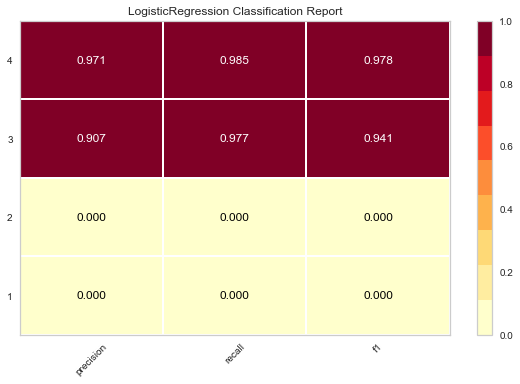

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [19]:
from yellowbrick.classifier import ClassificationReport
clfReport = ClassificationReport(reg)
clfReport.score(ZTest, yTest)
clfReport.show()